# Bước 5: So sánh Apriori vs FP-Growth

Mục tiêu:

- Chạy Apriori và FP-Growth trên cùng một `basket_bool`
- So sánh:
  - Thời gian chạy
  - Số lượng tập mục phổ biến (frequent itemsets)
  - Số lượng luật kết hợp sinh ra
  - Độ dài trung bình của itemset
- Minh hoạ bằng biểu đồ để sinh viên thấy rõ trade-off giữa:
  - Độ đầy đủ của luật
  - Thời gian tính toán
  - Tính phù hợp với dữ liệu lớn


In [1]:
# PARAMETERS (for papermill)

BASKET_BOOL_PATH = "data/processed/basket_bool.parquet"

# Dùng chung tham số với hai thuật toán
MIN_SUPPORT = 0.03
MAX_LEN = 3
METRIC = "lift"
MIN_THRESHOLD = 1.0


## Set up

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Determine correct project root
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    project_root = os.path.abspath("..")
else:
    project_root = cwd

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from apriori_library import (
    benchmark_apriori_vs_fpgrowth,
    AssociationRulesMiner,
    FPGrowthMiner,
    DataVisualizer,
)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12


## Tải basket_bool

In [3]:
basket_bool = pd.read_parquet(BASKET_BOOL_PATH)

print("=== Thông tin basket_bool ===")
print(f"- Số hoá đơn (rows): {basket_bool.shape[0]:,}")
print(f"- Số sản phẩm (columns): {basket_bool.shape[1]:,}")
print(f"- Tỷ lệ ô = 1 (có mua): {basket_bool.values.mean():.4f}")


=== Thông tin basket_bool ===
- Số hoá đơn (rows): 18,021
- Số sản phẩm (columns): 4,007
- Tỷ lệ ô = 1 (có mua): 0.0066


## Chạy benchmark

In [4]:
result = benchmark_apriori_vs_fpgrowth(
    basket_bool=basket_bool,
    min_support=MIN_SUPPORT,
    max_len=MAX_LEN,
    metric=METRIC,
    min_threshold=MIN_THRESHOLD,
)

summary = result["summary"]
summary


,algorithm,runtime_sec,n_itemsets,n_rules,avg_itemset_length
0,apriori,0.564229,145,22,1.075862
1,fpgrowth,3.237001,145,22,1.075862


## Biểu đồ so sánh thời gian

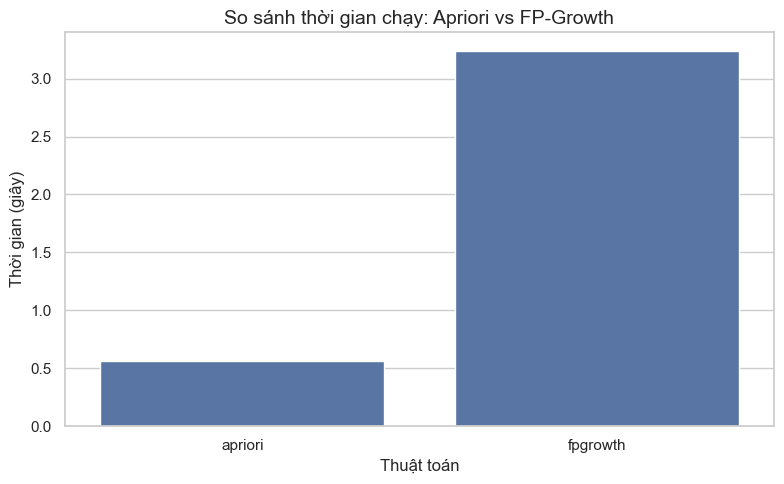

In [5]:
plt.figure()
sns.barplot(data=summary, x="algorithm", y="runtime_sec")
plt.title("So sánh thời gian chạy: Apriori vs FP-Growth")
plt.ylabel("Thời gian (giây)")
plt.xlabel("Thuật toán")
plt.tight_layout()
plt.show()


## Biểu đồ số lượng itemsets & rules

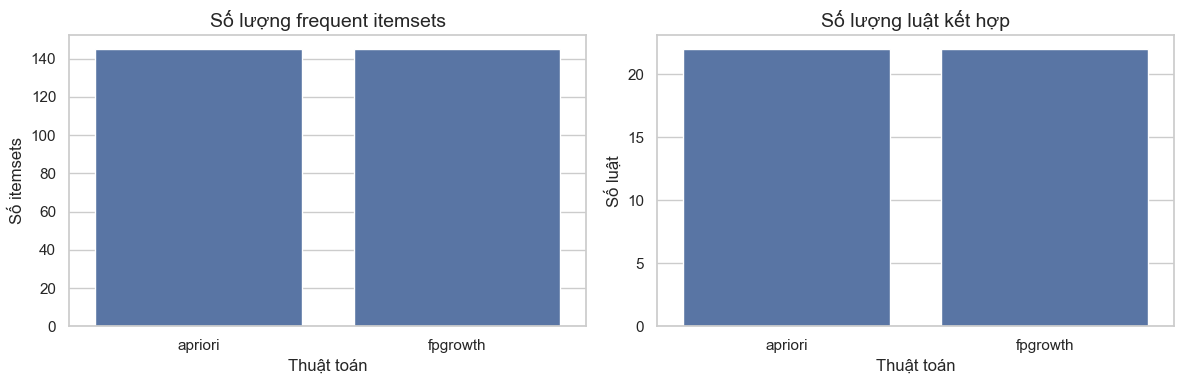

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(data=summary, x="algorithm", y="n_itemsets", ax=axes[0])
axes[0].set_title("Số lượng frequent itemsets")
axes[0].set_xlabel("Thuật toán")
axes[0].set_ylabel("Số itemsets")

sns.barplot(data=summary, x="algorithm", y="n_rules", ax=axes[1])
axes[1].set_title("Số lượng luật kết hợp")
axes[1].set_xlabel("Thuật toán")
axes[1].set_ylabel("Số luật")

plt.tight_layout()
plt.show()


## Độ dài trung bình iemset

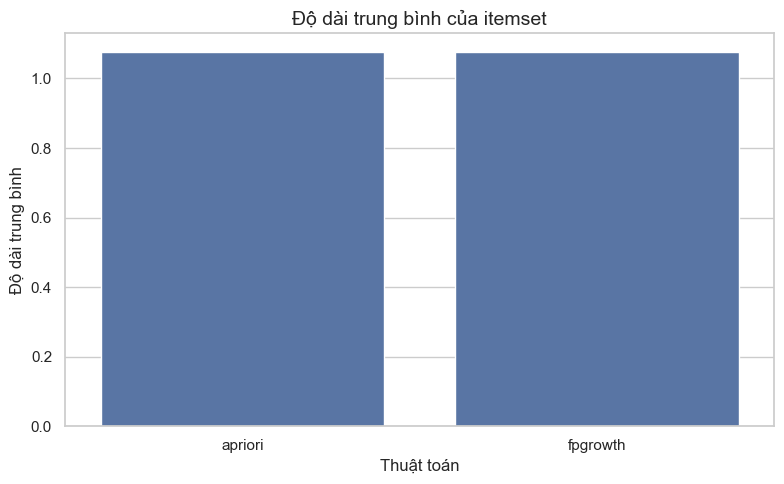

In [7]:
plt.figure()
sns.barplot(data=summary, x="algorithm", y="avg_itemset_length")
plt.title("Độ dài trung bình của itemset")
plt.xlabel("Thuật toán")
plt.ylabel("Độ dài trung bình")
plt.tight_layout()
plt.show()


## Một vài luật tiêu biểu từ mỗi thuật toán

In [8]:
cols_preview = [
    "antecedents_str",
    "consequents_str",
    "support",
    "confidence",
    "lift",
]

ap_rules = result["apriori_rules"].copy()
fp_rules = result["fpgrowth_rules"].copy()

# Thêm dạng chuỗi dễ đọc nếu chưa có (tuỳ trường hợp gọi)
if "antecedents_str" not in ap_rules.columns:
    miner_ap_tmp = AssociationRulesMiner(basket_bool=basket_bool)
    miner_ap_tmp.frequent_itemsets = result["apriori_itemsets"]
    miner_ap_tmp.rules = ap_rules
    ap_rules = miner_ap_tmp.add_readable_rule_str()

if "antecedents_str" not in fp_rules.columns:
    miner_fp_tmp = FPGrowthMiner(basket_bool=basket_bool)
    miner_fp_tmp.frequent_itemsets = result["fpgrowth_itemsets"]
    miner_fp_tmp.rules = fp_rules
    fp_rules = miner_fp_tmp.add_readable_rule_str()

print("=== Top 10 luật Apriori (theo lift) ===")
display(
    ap_rules.sort_values("lift", ascending=False)[cols_preview].head(10)
)

print("=== Top 10 luật FP-Growth (theo lift) ===")
display(
    fp_rules.sort_values("lift", ascending=False)[cols_preview].head(10)
)


=== Top 10 luật Apriori (theo lift) ===


,antecedents_str,consequents_str,support,confidence,lift
11,GREEN REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER,0.031963,0.618026,15.865302
10,PINK REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.031963,0.820513,15.865302
18,PINK REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,0.030242,0.776353,14.634584
19,ROSES REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER,0.030242,0.570084,14.634584
21,GARDENERS KNEELING PAD CUP OF TEA,GARDENERS KNEELING PAD KEEP CALM,0.030021,0.721333,14.475666
20,GARDENERS KNEELING PAD KEEP CALM,GARDENERS KNEELING PAD CUP OF TEA,0.030021,0.602450,14.475666
3,GREEN REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,0.038844,0.751073,14.158040
2,ROSES REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.038844,0.732218,14.158040
14,ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE RED,0.031241,0.642694,12.453752
15,ALARM CLOCK BAKELIKE RED,ALARM CLOCK BAKELIKE GREEN,0.031241,0.605376,12.453752


=== Top 10 luật FP-Growth (theo lift) ===


,antecedents_str,consequents_str,support,confidence,lift
11,GREEN REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER,0.031963,0.618026,15.865302
10,PINK REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.031963,0.820513,15.865302
18,PINK REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,0.030242,0.776353,14.634584
19,ROSES REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER,0.030242,0.570084,14.634584
21,GARDENERS KNEELING PAD CUP OF TEA,GARDENERS KNEELING PAD KEEP CALM,0.030021,0.721333,14.475666
20,GARDENERS KNEELING PAD KEEP CALM,GARDENERS KNEELING PAD CUP OF TEA,0.030021,0.602450,14.475666
3,GREEN REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,0.038844,0.751073,14.158040
2,ROSES REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.038844,0.732218,14.158040
14,ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE RED,0.031241,0.642694,12.453752
15,ALARM CLOCK BAKELIKE RED,ALARM CLOCK BAKELIKE GREEN,0.031241,0.605376,12.453752


Đang chạy với min_support = 0.05...
Đang chạy với min_support = 0.04...
Đang chạy với min_support = 0.03...
Đang chạy với min_support = 0.02...
Đang chạy với min_support = 0.015...
Đang chạy với min_support = 0.01...
❌ Apriori thất bại ở mức 0.01 do tràn bộ nhớ!


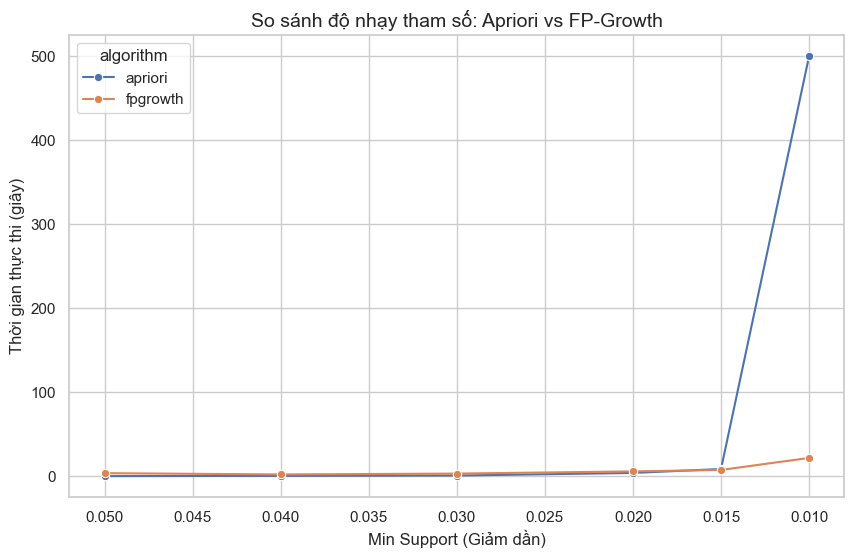

In [12]:
results_list = []
support_levels = [0.05, 0.04, 0.03, 0.02, 0.015, 0.01]

for sup in support_levels:
    print(f"Đang chạy với min_support = {sup}...")
    try:
        # Chạy benchmark bình thường
        res = benchmark_apriori_vs_fpgrowth(
            basket_bool=basket_bool,
            min_support=sup,
            max_len=3,
            metric="lift",
            min_threshold=1.0
        )
        temp_df = res['summary'].copy()
        temp_df['min_support'] = sup
        results_list.append(temp_df)
    except MemoryError:
        print(f"❌ Apriori thất bại ở mức {sup} do tràn bộ nhớ!")
        # Nếu Apriori lỗi, ta vẫn cố chạy riêng FP-Growth để có số liệu vẽ biểu đồ
        from mlxtend.frequent_patterns import fpgrowth
        import time
        
        t0 = time.time()
        fpgrowth(basket_bool, min_support=sup, use_colnames=True)
        t_fp = time.time() - t0
        
        # Ghi nhận kết quả: Apriori cho giá trị cực lớn (để thấy độ dốc), FP-Growth lấy giá trị thật
        failed_res = pd.DataFrame([
            {'algorithm': 'apriori', 'runtime_sec': 500, 'min_support': sup}, # 500s là số giả định để vẽ
            {'algorithm': 'fpgrowth', 'runtime_sec': t_fp, 'min_support': sup}
        ])
        results_list.append(failed_res)
# Sau đó vẽ biểu đồ như cũ...

# 3. Vẽ biểu đồ đường so sánh thời gian (Question 2)
plt.figure(figsize=(10, 6))
sns.lineplot(data=pd.concat(results_list, ignore_index=True), x="min_support", y="runtime_sec", hue="algorithm", marker="o")
plt.gca().invert_xaxis() # Đảo ngược trục X để thấy support giảm dần từ trái sang phải
plt.title("So sánh độ nhạy tham số: Apriori vs FP-Growth")
plt.xlabel("Min Support (Giảm dần)")
plt.ylabel("Thời gian thực thi (giây)")
plt.grid(True)
plt.show()